# Homework 2 : CUAHSI VU : Snow Hydrology

We'll use the setup from the `homework_2_B_setup.ipynb` notebook for this exercise as well and we will use the forcing file with the rescaled wind from the `homework_2_C_exercise_1.ipynb` notebook. If you think that you comprised that setup in a previous exercise, just rerun `homework_2_B_setup.ipynb` and `homework_2_C_exercise_1.ipynb` before continuing.

As before, remember that you want to save your notebooks in a place other than the `examples` directory tree, because files you save there may be deleted and overwritten the next time you start your virtual machine. Save your files somewhere in the `work` directory tree: `work/homework_2` would be a great place for them. So click on "_File --> Save Notebook As..._" and save this notebook as `work/homework_2/homework_2_D_exercise_2.ipynb` before you continue. If things go hopelessly wrong, you can always start over again with the original notebook in your `examples` directory tree.

## D. Homework 2 Exercise 2

### Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # if you want to do some plotting using matplotlib (optional)
from pysumma.Simulation import Simulation # create Simulation objects
from pysumma.hydroshare import hydroshare # create hydroshare objects to upload to HydroShare
from pysumma.LocalParamInfo import LocalParamInfo # modify local parameters.
import numpy as np # provide some mathematical functions
import xarray as xr # read, write, manipulate and analyze NetCDF files
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
resource_id = '05adaf5618ee4dbbbf04195db376cbb4'
case_path = '/home/jovyan/work/{}/{}/data/contents/umpqua'.format(resource_id, resource_id)
filemanager_path = case_path+'/settings/snow_fileManager.txt'
summa_code_path = '/opt/summa'

### Functions

In this section we will pre-define some functions we will use in the rest of the notebook to modify the forcings. In this second exercise we will look at the effects of different methods to estimate incoming longwave radiation on the snow simulations. To do this, we will read the rescaled forcing file (identified by the filename modifier `9697_rescaled_wind`) into an `xarray Dataset` and we will then calculate new longwave fluxes, which we will write to a new file. We then modify the SUMMA input file that points to the forcing file to be used (the [forcing file list](https://summa.readthedocs.io/en/latest/input_output/SUMMA_input/#list-of-forcing-files-file)). We will show an example below.

#### Update the forcing file list

The following function will update the forcing file list so that SUMMA will read the right forcing file.

In [3]:
def update_force_file_list(s, new_force_filename):
    '''Update the forcing file list
       s: SUMMA simulation instance
       new: new forcing filename
       Note this only works if there is a single forcing file'''
    fp = s.setting_path.get_value() + s.forcing_list.get_value()
    with open(fp, 'r') as f:
        lines = f.readlines()
    lines[-1] = "'{}'".format(new_force_filename.split('/')[-1])
    with open(fp, 'w') as f:
        f.writelines(lines)

#### Calculate incoming longwave radiation

**Calculation of vapor pressure from specific humidity**

Most methods for estimating incoming longwave radiation from other variables require some combination of air temperature, a measure of humidity (vapor pressure or specific humidity), and perhaps some other variables. First, we will derive the relationship between specific humidity and vapor pressure, since we have specific humidity as part of the SUMMA forcing file.

We begin with definitions of relative humidity and rearranging,

$$ RH = \frac{w}{w_s} = \frac{e}{e_s} \rightarrow e = \frac{e_s \cdot w}{w_s} $$

Given specific humidity as the mass mixing ratio of water vapor we can rearrange, 

$$q = \frac{w}{w+1} \rightarrow w = -\frac{q}{q-1}$$

And finally, using the conversion factor:

$$ w_s \approx 0.622 \frac{e_s}{p} $$

we are able to write the vapor pressure in terms of the specific humidity and air pressure:

$$ e = -\frac{e_s}{w_s}\left(\frac{q}{q-1}\right) \approx -1.607 \cdot p \left(\frac{q}{q-1}\right) $$

With this we can define a number of functions for estimating longwave radiation.

**Methods for estimating longwave radiation**

We define the following five functions for estimating longwave radiation (the references are provide in the functions): 
* Prata
* TVA
* Satterlund
* Anderson
* Dokia

For each of the functions, the units of the inputs are consistent with the units in the SUMMA forcing files. Note that there are also a few helper functions that are used by one or more of the methods.

In [4]:
# Stephan-Boltzmann constant (J/s/m^2/K^4)
STEFAN = 5.67e-8


def vapor_pressure(air_pressure, spec_humid):
    """See above for derivation"""
    return -1.607 * air_pressure * spec_humid / (spec_humid - 1)


def longwave_prata(air_temp, vapor_pressure):
    """
    Reference:
        Prata, A.J., 1996. A new long-wave formula for estimating
        downward clear-sky radiation at the surface. Q. J. R. Meteor.
        Soc. 122 (533), 1127–1151, doi:10.1002/qj.49712253306.
    """
    z = 46.5 * (vapor_pressure / air_temp)
    emissivity = 1 - (1 + z) * np.exp(-np.sqrt(1.2 + 3 * z))
    return emissivity * np.power(air_temp, 4) * STEFAN
        
    
def longwave_tva(air_temp, vapor_pressure):
    """
    Reference:
        Tennessee Valley Authority, 1972. Heat and mass transfer between a
        water surface and the atmosphere. Tennessee Valley Authority, Norris,
        TN. Laboratory report no. 14. Water resources research report no. 0-6803.
    """
    emissivity = 0.74 + 0.0049 * vapor_pressure/10
    return emissivity * np.power(air_temp, 4) * STEFAN


def longwave_satterlund(air_temp, vapor_pressure):
    """
    Reference:
        Satterlund, D.R., 1979. An improved equation for estimating long-wave
        radiation from the atmosphere. Water Resour. Res. 15 (6), 1649–1650,
        doi:10.1029/WR015i006p01649.
    """
    vp = vapor_pressure / 10
    emissivity = 1.08 * (1 - np.exp(-np.power(vp, air_temp/2016)))
    return emissivity * np.power(air_temp, 4) * STEFAN


def longwave_anderson(air_temp, vapor_pressure):
    """
    Referencce:
        Anderson, E.R., 1954. Energy budget studies, water loss
        investigations: lake Hefner studies. U.S. Geol. Surv. Prof. Pap. 269,
        71–119 [Available from U.S. Geological Survey, 807 National Center,
        Reston, VA 20192.].
    """
    emissivity = 0.68 + 0.036 * np.power(vapor_pressure/10, 0.5)
    return emissivity * np.power(air_temp, 4) * STEFAN


def cloud_correction(shortwave, lat=43.03, highlimit=0.6, lowlimit=0.35):
    """Converted from cloudfactor_Jessica.m"""
    doy = shortwave.time.dt.dayofyear
    s0 = 1360                     # Solar constant (W/m^2)
    phi = lat * 2 * np.pi / 365   # Convert to radian
    # Declination in radians
    delta = (2 * np.pi / 365) * (23.45 * np.sin(2 * np.pi * (284 + doy) / 365))
    
    # Top of atmosphere radiation
    hs = np.arccos(-np.tan(phi) * np.tan(delta))
    q0 = s0 * (1/np.pi) * (
        hs * np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.sin(hs))
    
    # Fraction of recieved radiation
    k = shortwave / q0
    
    # Cloud cover fraction
    cloud_frac = 1 - ((k - lowlimit) / (highlimit - lowlimit))
    cloud_frac = cloud_frac.where(cloud_frac > 0, other=0.0)
    cloud_frac = cloud_frac.where(cloud_frac < 1, other=1.0)
    return cloud_frac
    
    
def longwave_dokia(air_temp, vapor_pressure, shortwave):
    """
    References:
      -Clear sky:
        Dilley, A. C., and D. M. O<92>Brien (1998), Estimating downward clear sky
        long-wave irradiance at the surface from screen temperature and precipitable
        water, Q. J. R. Meteorol. Soc., 124, 1391<96> 1401.
      -Cloudy sky:
        Kimball, B. A., S. B. Idso, and J. K. Aase (1982), A model of thermal                                                                                          
        radiation from partly cloudy and overcast skies, Water Resour. Res., 18,                                                                                       
        931<96> 936.                                   
    """
    vp = vapor_pressure / 1000 # Convert to kPa
    w = 4560 * (vp / air_temp) # Prata (1996) approximation for precipitable water
    
    # Clear sky component of longwave
    lw_clear = 59.38 + 113.7 * np.power(air_temp / 273.16, 6) + 96.96 * np.sqrt(w / 25)
    
    # Cloud cover corrections
    c = cloud_correction(shortwave)
    cloud_temp = air_temp - 11
    winter = np.logical_or(vp.time.dt.month <= 2, vp.time.dt.month == 12)
    summer = np.logical_and(vp.time.dt.month <= 8, vp.time.dt.month >=6)
    cloud_temp[winter] -= 2
    cloud_temp[summer] += 2
    
    # Cloudy sky component of longwave
    eps8z = 0.24 + 2.98e-6 * np.power(vp, 2.0) * np.exp(3000/air_temp)
    tau8 = 1 - eps8z * (1.4 - (0.4 * eps8z))
    f8 = -0.6732 + 0.6240e-2 * cloud_temp - 0.914e-5 * np.power(cloud_temp, 2.0)
    lw_cloud = tau8 * c * f8 * STEFAN * np.power(cloud_temp, 4)   
    return lw_clear + lw_cloud

***
***
### Example (**Anderson**):

Create a SUMMA simulation object.

In [5]:
S = Simulation(case_data=filemanager_path, summa_code=summa_code_path)

ModelOuput master file filepath: /opt/summa/build/source/dshare/var_lookup.f90


Open the forcing file for this simulation and read the file into an `xarray Dataset` object. Note that the name of the forcing file is stored in the forcing list file. The location of that file is given by:

In [6]:
forcing_file_list = S.file_dir+'/'+S.forcing_list.filename
forcing_file_list

'/home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/settings/snow_zForcingFileList.txt'

If you look in that file, you will see that the name of the forcing file is `Storck_AboveCanopyPP_9697_rescaled_wind.nc`. If it is something else, change it by running the `update_force_file_list()` command. Note that this assumes that the forcing file exists. It will if you have run through the previous notebook. The directory for that file is given by

In [7]:
S.input_path.filepath

'/home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/forcing/'

As before, we can use `xarray` to read the file into an `xarray Dataset`.

In [8]:
force_file_wind  = S.input_path.filepath + '/' + 'Storck_AboveCanopyPP_9697_rescaled_wind.nc'
force_wind = xr.open_dataset(force_file_wind)

To examine the contents of the file, you can simply type the name of the `Dataset`

In [9]:
force_wind

<xarray.Dataset>
Dimensions:    (hru: 2, time: 1770)
Coordinates:
  * time       (time) datetime64[ns] 1996-11-25T21:59:59.999996640 ...
Dimensions without coordinates: hru
Data variables:
    hruId      (hru) int32 ...
    latitude   (hru) float64 ...
    longitude  (hru) float64 ...
    data_step  timedelta64[ns] ...
    LWRadAtm   (time, hru) float64 ...
    SWRadAtm   (time, hru) float64 ...
    airpres    (time, hru) float64 ...
    airtemp    (time, hru) float64 ...
    pptrate    (time, hru) float64 ...
    spechum    (time, hru) float64 ...
    windspd    (time, hru) float64 ...
Attributes:
    dataset_orig_path:  /d2/anewman/summa/summaTestCases/testCases_data/input...
    history:            Tue Sep 27 21:53:13 2016: ncrename -d nHRU,hru ./inpu...
    NCO:                "4.6.0"

To check that the winds are indeed different, we can quickly plot them

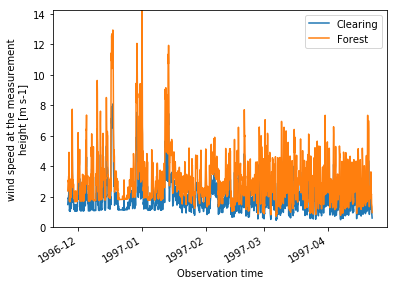

In [10]:
force_wind['windspd'].isel(hru=0).plot(label='Clearing')
force_wind['windspd'].isel(hru=1).plot(label='Forest')
plt.ylim(0,force_wind['windspd'].max())
plt.legend()

In this notebook we will examine different ways for estimating downward longwave, which we will assume is the same for the clearing and above the forest canopy (is that a reasonable assumption?). We can take a quick look at the downwelling longwave in the forcing file

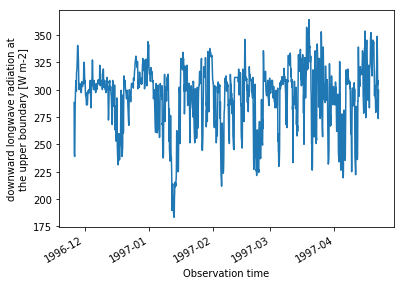

In [11]:
force_wind.LWRadAtm.isel(hru=0).plot()

Now let's generate a new forcing dataset based on one of the longwave algorithms. Here we'll use Anderson as an example, which takes air temperature and vapor pressure as input (so we first need to calculate the vapor pressure). 

In [12]:
vp = vapor_pressure(force_wind['airpres'], force_wind['spechum'])
lw_anderson = longwave_anderson(force_wind['airtemp'], vp)

And let's plot the two different longwave time series for the first hru.

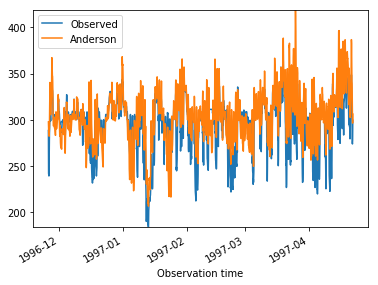

In [13]:
force_wind.LWRadAtm.isel(hru=0).plot(label='Observed')
lw_anderson.isel(hru=0).plot(label='Anderson')
ymin = min(force_wind.LWRadAtm.isel(hru=0).min(), lw_anderson.isel(hru=0).min())
ymax = max(force_wind.LWRadAtm.isel(hru=0).max(), lw_anderson.isel(hru=0).max())
plt.ylim((ymin, ymax))
plt.legend()

We'll do a quick run with the rescaled wind forcings

In [14]:
ds_rescaled_wind, outfile_rescaled_wind = S.execute(run_suffix='rescaled_wind', run_option='local')

file_suffix is 'rescaled_wind'.
file_master is '/home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/settings/snow_fileManager.txt'.
start at 19:03:48
Name of Model Output control file: /home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/settings/snow_zOutputControl.txt
decisions file =  /home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/settings/snow_zDecisions.txt
   1 simulStart: 1996-11-28 00:00
   2 simulFinsh: 1997-04-22 02:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: SiB_Type
   6 stomResist: BallBerry
   7 num_method: itertive
   8 fDerivMeth: analytic
   9 LAI_method: monTable
  10 f_Richards: mixdform
  11 groundwatr: qTopmodl
  12 hc_profile: pow_prof
  13 bcUpprTdyn: nrg_flux
  14 bcLowrTdyn: zeroFlux
  15 bcUpprSoiH: liq_flux
  16 bcLowrSoiH: zeroFlux
  17 veg_traits: CM_QJRMS1988
  18 canopyEmi

Finally, we'll write our new Anderson forcing to file and we will do simulations with the new longwave time series (the other forcings will remain unchanged).

Writing this to file, we'll use a few steps:
* copy the original forcing dataset to a new one
* replace the longwave values
* write a new forcing file
* replace the forcing file name in the forcing file list with the name of the new file

Once done we can just do the new simulation. Note that in this case we are re-using the existing simulation object `S`. We could use a somewhat different workflow here and create new simulation objects, but for now we recommend this workflow, because it is easy to get the input files mixed up. For details on each of the steps, see the previous notebook.

In [15]:
force_anderson = force_wind.copy(deep=True)
force_anderson['LWRadAtm'].values = lw_anderson.values # replace the longwave values
force_file_anderson = force_file_wind.replace('9697_rescaled_wind', '9697_anderson')
force_anderson.to_netcdf(force_file_anderson, format='NETCDF3_CLASSIC')
update_force_file_list(S, force_file_anderson)
ds_anderson, out_anderson = S.execute(run_suffix='lw_anderson', run_option='local')

file_suffix is 'lw_anderson'.
file_master is '/home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/settings/snow_fileManager.txt'.
start at 19:03:51
Name of Model Output control file: /home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/settings/snow_zOutputControl.txt
decisions file =  /home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/settings/snow_zDecisions.txt
   1 simulStart: 1996-11-28 00:00
   2 simulFinsh: 1997-04-22 02:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: SiB_Type
   6 stomResist: BallBerry
   7 num_method: itertive
   8 fDerivMeth: analytic
   9 LAI_method: monTable
  10 f_Richards: mixdform
  11 groundwatr: qTopmodl
  12 hc_profile: pow_prof
  13 bcUpprTdyn: nrg_flux
  14 bcLowrTdyn: zeroFlux
  15 bcUpprSoiH: liq_flux
  16 bcLowrSoiH: zeroFlux
  17 veg_traits: CM_QJRMS1988
  18 canopyEmis:

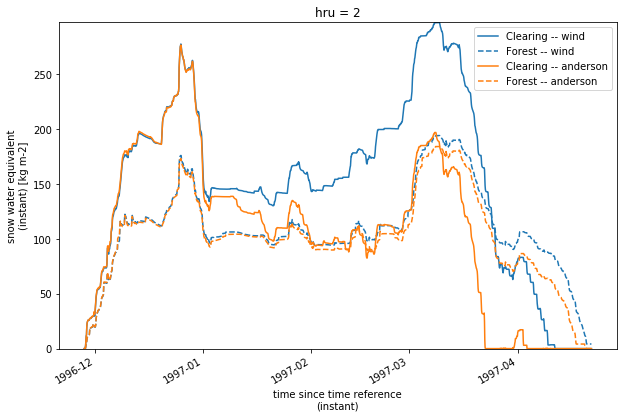

In [18]:
plt.figure(figsize=(10,6))
ds_rescaled_wind.scalarSWE.isel(hru=0).plot(label='Clearing -- wind', 
                                            color=cycle[0], linestyle='-')
ds_rescaled_wind.scalarSWE.isel(hru=1).plot(label='Forest -- wind',
                                            color=cycle[0], linestyle='--')
ds_anderson.scalarSWE.isel(hru=0).plot(label='Clearing -- anderson',
                                        color=cycle[1], linestyle='-')
ds_anderson.scalarSWE.isel(hru=1).plot(label='Forest -- anderson',
                                        color=cycle[1], linestyle='--')
max_swe = max(ds_rescaled_wind.scalarSWE.max(), ds_anderson.scalarSWE.max())
plt.ylim(0,max_swe)
plt.legend()

Here we see a large change in the snow in the clearing and a much smaller change in the snow below the canopy. You should try remaking the plot with the observations super-imposed as well (see previous notebook).

**Keep in mind that the file with the forcing file list now points to the file with the Anderson longwave file. If you want to rerun with any other forcing you will need to make sure that the file reported in `forcing_file_list` points to the right input file.**

You can navigate to this file in the file browser to the left.

### Exercise

Now it is up to you. Use different empirical methods to estimate the incoming longwave irradiance and compare the simulations with each other. Document the impact on the simulated snowpack in a forest clearing and under a forest canopy.

In the next exercise we take this a step further, but for now we just want to ensure that you can create new longwave forcings, use them as input to SUMMA and compare the impacts of these changes on snow pack development.

Finally a few hints and things to keep in mind: It is easy to get confused with the model setup and the simulations. If you make changes to the forcings and the simulations do not change, make sure that your simulation object actually reads the right forcing file.

All the forcing files should end up in the directory : `/home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/
data/contents/umpqua/forcing/`
You can inspect that directory in the file browser to the left (you can also do that in a terminal if you are familiar with unix).

To make sure that the right file is actually being read, you can inspect the `forcing_file_list`, which is at:
`/home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/
data/contents/umpqua/settings/snow_zForcingFileList.txt`

Keep in mind that commands in a jupyter notebook can be executed in any order, but that that may affect the results. When things don't make sense, re-install the setup for homework 2 (execute the cells in `homework_2_B_setup.ipynb`) and rerun `homework_2_C_Exercise_1.ipynb` to rescale the wind speed above the forest. Then rerun this notebook. To make sure you start afresh, you should also restart the kernel (so there are no old versions in memory). You can do this by going to `Kernel --> Restart Kernel...` and re-executing the notebook cells or selecting `Kernel --> Restart Kernel and Run All Cells`. Normally you would not redo all the model simulations every time, but since the simulations are short, we'll use that method for now.

***
***

### Prata:

In [19]:
vp = vapor_pressure(force_wind['airpres'], force_wind['spechum'])

# Prata Longwave:
lw_prata = longwave_prata(force_wind['airtemp'], vp)
force_prata = force_wind.copy(deep=True)
force_prata['LWRadAtm'].values = lw_prata # replace the longwave values
force_file_prata = force_file_wind.replace('9697_anderson', '9697_prata')
force_prata.to_netcdf(force_file_prata, format='NETCDF3_CLASSIC')
update_force_file_list(S, force_file_prata)
ds_prata, out_prata = S.execute(run_suffix='lw_prata', run_option='local')

file_suffix is 'lw_prata'.
file_master is '/home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/settings/snow_fileManager.txt'.
start at 19:04:26
Name of Model Output control file: /home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/settings/snow_zOutputControl.txt
decisions file =  /home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/settings/snow_zDecisions.txt
   1 simulStart: 1996-11-28 00:00
   2 simulFinsh: 1997-04-22 02:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: SiB_Type
   6 stomResist: BallBerry
   7 num_method: itertive
   8 fDerivMeth: analytic
   9 LAI_method: monTable
  10 f_Richards: mixdform
  11 groundwatr: qTopmodl
  12 hc_profile: pow_prof
  13 bcUpprTdyn: nrg_flux
  14 bcLowrTdyn: zeroFlux
  15 bcUpprSoiH: liq_flux
  16 bcLowrSoiH: zeroFlux
  17 veg_traits: CM_QJRMS1988
  18 canopyEmis: si

***
### Dokia:

In [20]:
# Dokia Longwave:
shortwave = force_wind['SWRadAtm']
lw_dokia = longwave_dokia(force_wind['airtemp'], vp, shortwave)
force_dokia = force_wind.copy(deep=True)
force_dokia['LWRadAtm'].values = lw_dokia # replace the longwave values
force_file_dokia = force_file_wind.replace('9697_prata', '9697_dokia')
force_dokia.to_netcdf(force_file_dokia, format='NETCDF3_CLASSIC')
update_force_file_list(S, force_file_dokia)
ds_dokia, out_dokia = S.execute(run_suffix='lw_dokia', run_option='local')

file_suffix is 'lw_dokia'.
file_master is '/home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/settings/snow_fileManager.txt'.
start at 19:04:33
Name of Model Output control file: /home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/settings/snow_zOutputControl.txt
decisions file =  /home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/settings/snow_zDecisions.txt
   1 simulStart: 1996-11-28 00:00
   2 simulFinsh: 1997-04-22 02:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: SiB_Type
   6 stomResist: BallBerry
   7 num_method: itertive
   8 fDerivMeth: analytic
   9 LAI_method: monTable
  10 f_Richards: mixdform
  11 groundwatr: qTopmodl
  12 hc_profile: pow_prof
  13 bcUpprTdyn: nrg_flux
  14 bcLowrTdyn: zeroFlux
  15 bcUpprSoiH: liq_flux
  16 bcLowrSoiH: zeroFlux
  17 veg_traits: CM_QJRMS1988
  18 canopyEmis: si

***
### Plot results:

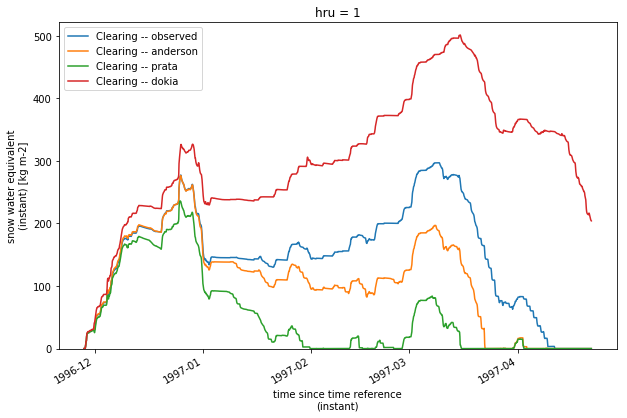

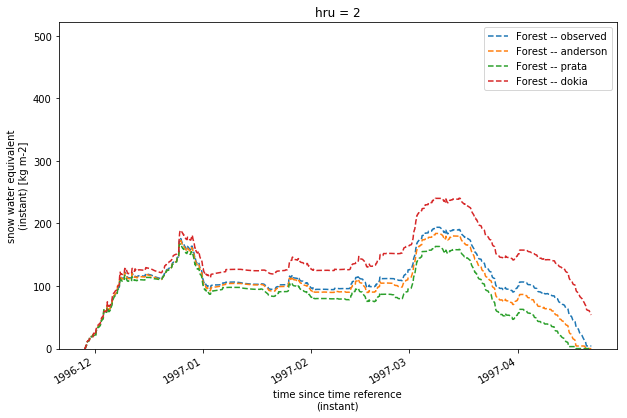

In [23]:
# SWE:

# Clearing:
plt.figure(0,figsize=(10,6))
ds_rescaled_wind.scalarSWE.isel(hru=0).plot(label='Clearing -- observed', 
                                            color=cycle[0], linestyle='-')

ds_anderson.scalarSWE.isel(hru=0).plot(label='Clearing -- anderson',
                                        color=cycle[1], linestyle='-')

ds_prata.scalarSWE.isel(hru=0).plot(label='Clearing -- prata',
                                        color=cycle[2], linestyle='-')

ds_dokia.scalarSWE.isel(hru=0).plot(label='Clearing -- dokia',
                                        color=cycle[3], linestyle='-')

max_swe = max(ds_rescaled_wind.scalarSWE.max(), ds_dokia.scalarSWE.max())
plt.ylim(0,max_swe+20)
plt.legend()


# Forest:
plt.figure(1,figsize=(10,6))
ds_rescaled_wind.scalarSWE.isel(hru=1).plot(label='Forest -- observed',
                                            color=cycle[0], linestyle='--')

ds_anderson.scalarSWE.isel(hru=1).plot(label='Forest -- anderson',
                                        color=cycle[1], linestyle='--')

ds_prata.scalarSWE.isel(hru=1).plot(label='Forest -- prata',
                                        color=cycle[2], linestyle='--')

ds_dokia.scalarSWE.isel(hru=1).plot(label='Forest -- dokia',
                                        color=cycle[3], linestyle='--')

max_swe = max(ds_rescaled_wind.scalarSWE.max(), ds_dokia.scalarSWE.max())
plt.ylim(0,max_swe+20)
plt.legend()

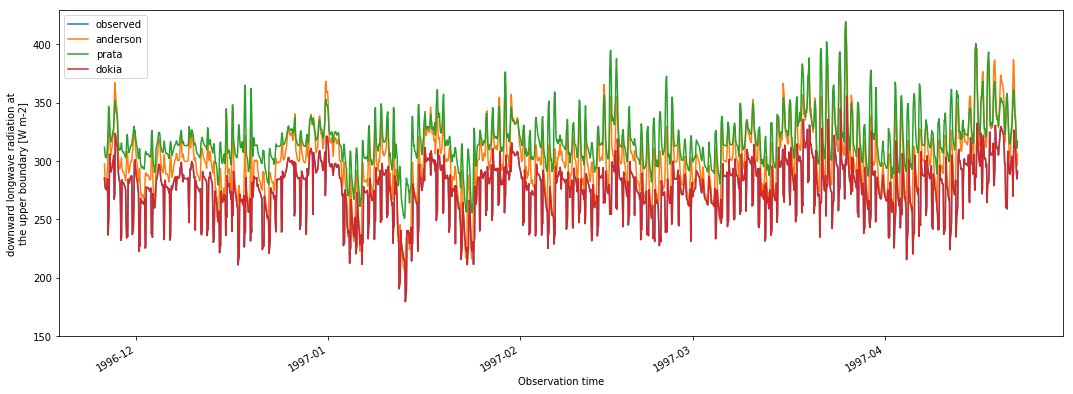

In [49]:
# Incoming LW (same for both clearing and forest):

plt.figure(0,figsize=(18,6))

force_wind['LWRadAtm'].isel(hru=0).plot(label='observed',color=cycle[0], linestyle='-')
force_anderson['LWRadAtm'].isel(hru=0).plot(label='anderson',color=cycle[1], linestyle='-')
force_prata['LWRadAtm'].isel(hru=0).plot(label='prata',color=cycle[2], linestyle='-')
force_dokia['LWRadAtm'].isel(hru=0).plot(label='dokia',color=cycle[3], linestyle='-')

max_LW = force_prata['LWRadAtm'].max()
plt.ylim(150,max_LW+10)
plt.legend()


<xarray.DataArray 'LWRadAtm' (time: 1770, hru: 2)>
array([[285.650006, 285.650006],
       [279.103689, 279.103689],
       [276.537717, 276.537717],
       ...,
       [289.739588, 289.739588],
       [284.802458, 284.802458],
       [291.191904, 291.191904]])
Coordinates:
  * time     (time) datetime64[ns] 1996-11-25T21:59:59.999996640 1996-11-26 ...
Dimensions without coordinates: hru
Attributes:
    units:      W m-2
    long_name:  downward longwave radiation at the upper boundary
    v_type:     scalarv

***
***

## On to the next step

That's it for the second part of the second homework as far as the model simulations go. Prof. Lundquist will talk more about the analysis that you need to do on these simulations. You can do the analysis here in this notebook if python is your analysis software of choice or you can upload your output to HydroShare (in NetCDF or csv format) to do additional analysis.

Save this notebook and close the tab. You can also right-click on the file in the left panel if it has a green dot next to it and select "_Shutdown kernel_" from the popup menu to stop the python session that is executing the commands in this notebook. Then open the next notebook: 
`work/homework_2/homework_2_E_exercise_3.ipynb`.
